# Topic Modeling with Singular Value Decomposition
* Text Retrieval and Mining, BSc BAN, 2023-2024
* Author: [Julien Rossi](mailto:j.rossi@uva.nl)



## Additional Resources

* These [slides](https://nlp.stanford.edu/IR-book/essir2011/pdf/18lsi.pdf) from Stanford are complete with mathematical details and illustrations
* This [website](http://www.alias-i.com/lingpipe/demos/tutorial/svd/read-me.html) shows a detailed implementation, using Java
* The [IR Book](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf) has a chapter dedicated to SVD - LSI
* This [Blog Post by Jonathan Hui](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491) elaborates on the difference between PCA and SVD

## Problem Statement

We still consider we want vectors as text representation and we want cosine similarity of these vectors to give a good measure of text similarity, in terms what the text means.

We identify the weaknesses of lexical methods of text representation (in short: Bag of Words), we are in the context of 2 texts that we estimate as similar, but the cosine similarity is still low:

* Synonyms: will create additional dimensions for one meaning (`ocean` and `sea`, `cat` and `kitty`, `empty` and `void`). **BUT** the dot-product over these dimensions will be `0` and not contribute to cosine similarity.
* Semantics: BoW do not care about sentence composition, and meaning emerges from putting words together in some order

We are looking for ways to identify more accurately *what* a document talks about rather than *how* it talks about it.



## Intuition

Take 2 different terms, it is likely that they have a close meaning if they appear in the neighborhood of same other terms.

For the example, we consider a corpus of generic texts, like a collection of blog posts:
* `sea` and `ocean` are somehow synonyms (not exact synonyms though), as they appear both of them separately around the same words, like `boat`, `navigation`, `ship`, etc...

* Also, some groups of terms will appear a lot together in a group of documents, forming some *blobs* of non-zeros in the Term-Document Matrix, provided we re-order rows and columns to put them close together



---




Say we have a collection of food blog posts, both vegetarian and based on meat products.

Here is the original Term-Document Matrix:

$\begin{bmatrix}
 & chicken & lettuce & beef & tomato & pork \\
veg\_01  & 0 & 2 & 0 & 6 & 0 \\
meat\_01 & 8 & 1 & 2 & 1 & 0 \\
meat\_02 & 1 & 0 & 1 & 0 & 9 \\
veg\_02  & 0 & 8 & 0 & 10 & 0 \\
\end{bmatrix}$



---


When we re-order it:

$\begin{bmatrix}
 & chicken & beef & pork & tomato & lettuce \\
meat\_01 & 8 & 2 & 0 & 1 & 1 \\
meat\_02 & 1 & 1 & 9 & 0 & 0 \\
veg\_01  & 0 & 0 & 0 & 2 & 6 \\
veg\_02  & 0 & 0 & 0 & 8 & 10 \\
\end{bmatrix}$


---

Once re-ordered, we see 2 *blobs* appearing:
* Top-Left: meat themed
* Bottom-Right: vegetarian themed



### Illustrated

In [ ]:
import numpy as np

In [ ]:
mat_01 = np.array([
                   [0, 2, 0, 6, 0],
                   [8, 1, 2, 1, 0],
                   [1, 0, 1, 0, 9],
                   [0, 8, 0, 10, 0]
])

mat_02 = np.array([
                   [8, 2, 0, 1, 1],
                   [1, 1, 9, 0, 0],
                   [0, 0, 0, 2, 6],
                   [0, 0, 0, 8, 10]
])

terms_01 = ['chicken', 'lettuce', 'beef', 'tomato', 'pork']
docs_01 = ['veg_01', 'meat_01', 'meat_02', 'veg_02']

terms_02 = ['chicken', 'beef', 'pork', 'lettuce', 'tomato']
docs_02 = ['meat_01', 'meat_02', 'veg_01', 'veg_02']

matrixes = [
    {'name': 'Original', 'matrix': mat_01, 'terms': terms_01, 'docs': docs_01},
    {'name': 'Re-arranged', 'matrix': mat_02, 'terms': terms_02, 'docs': docs_02},
]

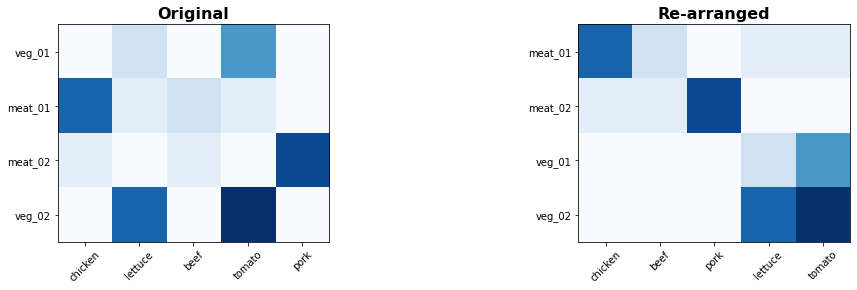

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

for ax, m in zip(axs, matrixes):
    _ = ax.imshow(m['matrix'], cmap='Blues', vmin=0, vmax=10)
    _ = ax.set_xticks(ticks=range(len(m['terms'])))
    _ = ax.set_xticklabels(labels=m['terms'], rotation=45, ha='center')
    _ = ax.set_yticks(ticks=range(len(m['docs'])))
    _ = ax.set_yticklabels(labels=m['docs'])
    _ = ax.set_title(m['name'], fontdict={'size': 16, 'weight': 'bold'})

plt.subplots_adjust(wspace=0.4)
plt.show()

### Reduction of Dimensions

These isolated blobs in the Term-Document Matrix indicate groups of words that could be either synonyms, or words that are used often in a specific context. The context being a set of words as well.

This singular cloud of words appear in documents that deal with one **topic**.
* MEAT: `chicken`, `beef` and `pork` appears usually together, or surrounded by the same words (like `slice`, `grill`, `sear`, ...)
* VEGETABLES: `lettuce` and `tomato` also co-appear or appear surrounded by the same words (like `dressing`, `chop`, ...)

We have a group of documents that contain a lot of the words in the **topic** MEAT and another group that contain a lot of the words in the **topic** VEGETABLES.

We could reduce the dimension of the text representation vectors if we can identify these *clouds* of words that form distinct **topics**, and have vectors where a text is represented as a proportion of topics.

In [ ]:
mat_03 = [
          [6, 1],
          [8, 0],
          [0, 8],
          [0, 10]
]

terms_03 = ['meat words', '', '', 'veg words', '']

matrixes.append({'name': 'Reduced to...', 'matrix': mat_03, 'terms': terms_03, 'docs': docs_02})

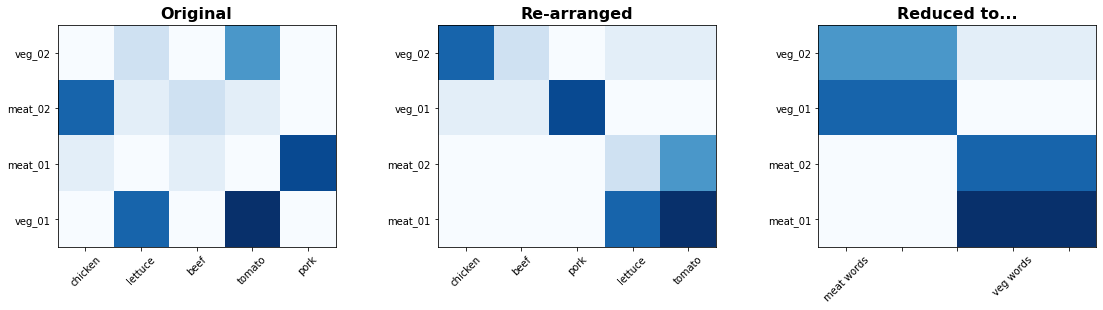

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

for ax, m in zip(axs, matrixes):
    _ = ax.imshow(m['matrix'], cmap='Blues', extent=[-0.5, 4.5, -0.5, 3.5])
    _ = ax.set_xticks(ticks=range(len(m['terms'])))
    _ = ax.set_xticklabels(labels=m['terms'], rotation=45, ha='center')
    _ = ax.set_yticks(ticks=range(len(m['docs'])))
    _ = ax.set_yticklabels(labels=m['docs'])
    _ = ax.set_title(m['name'], fontdict={'size': 16, 'weight': 'bold'})

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()

This sort of Dimensionality Reduction is done through Singular Value Decomposition.

## Mathematical Definition

Given a real matrix $X \in \mathcal{M}_{n \times m}$ of rank $r$
* There exists 3 matrices:
   * $U \in \mathcal{M}_{n \times r}$
   * $\Sigma \in \mathcal{M}_{r \times r}$
   * $V \in \mathcal{M}_{m \times r}$
* Such as $X = U \times \Sigma \times V^{T}$
* $\Sigma$ is a real diagonal matrix
   * $\forall (i,j), \: \Sigma_{i,j} = 0 \Leftrightarrow i \neq j$
   * The diagonal is made of the eigen-values of $X$ is decreasing order

We use a direct derivation of the Singular Value Decomposition Theorem, and consider only the sub-matrices that have an impact on the final result in $X$.
See [Link](https://www.overleaf.com/read/rkbqgfsrhbss) for the proof.


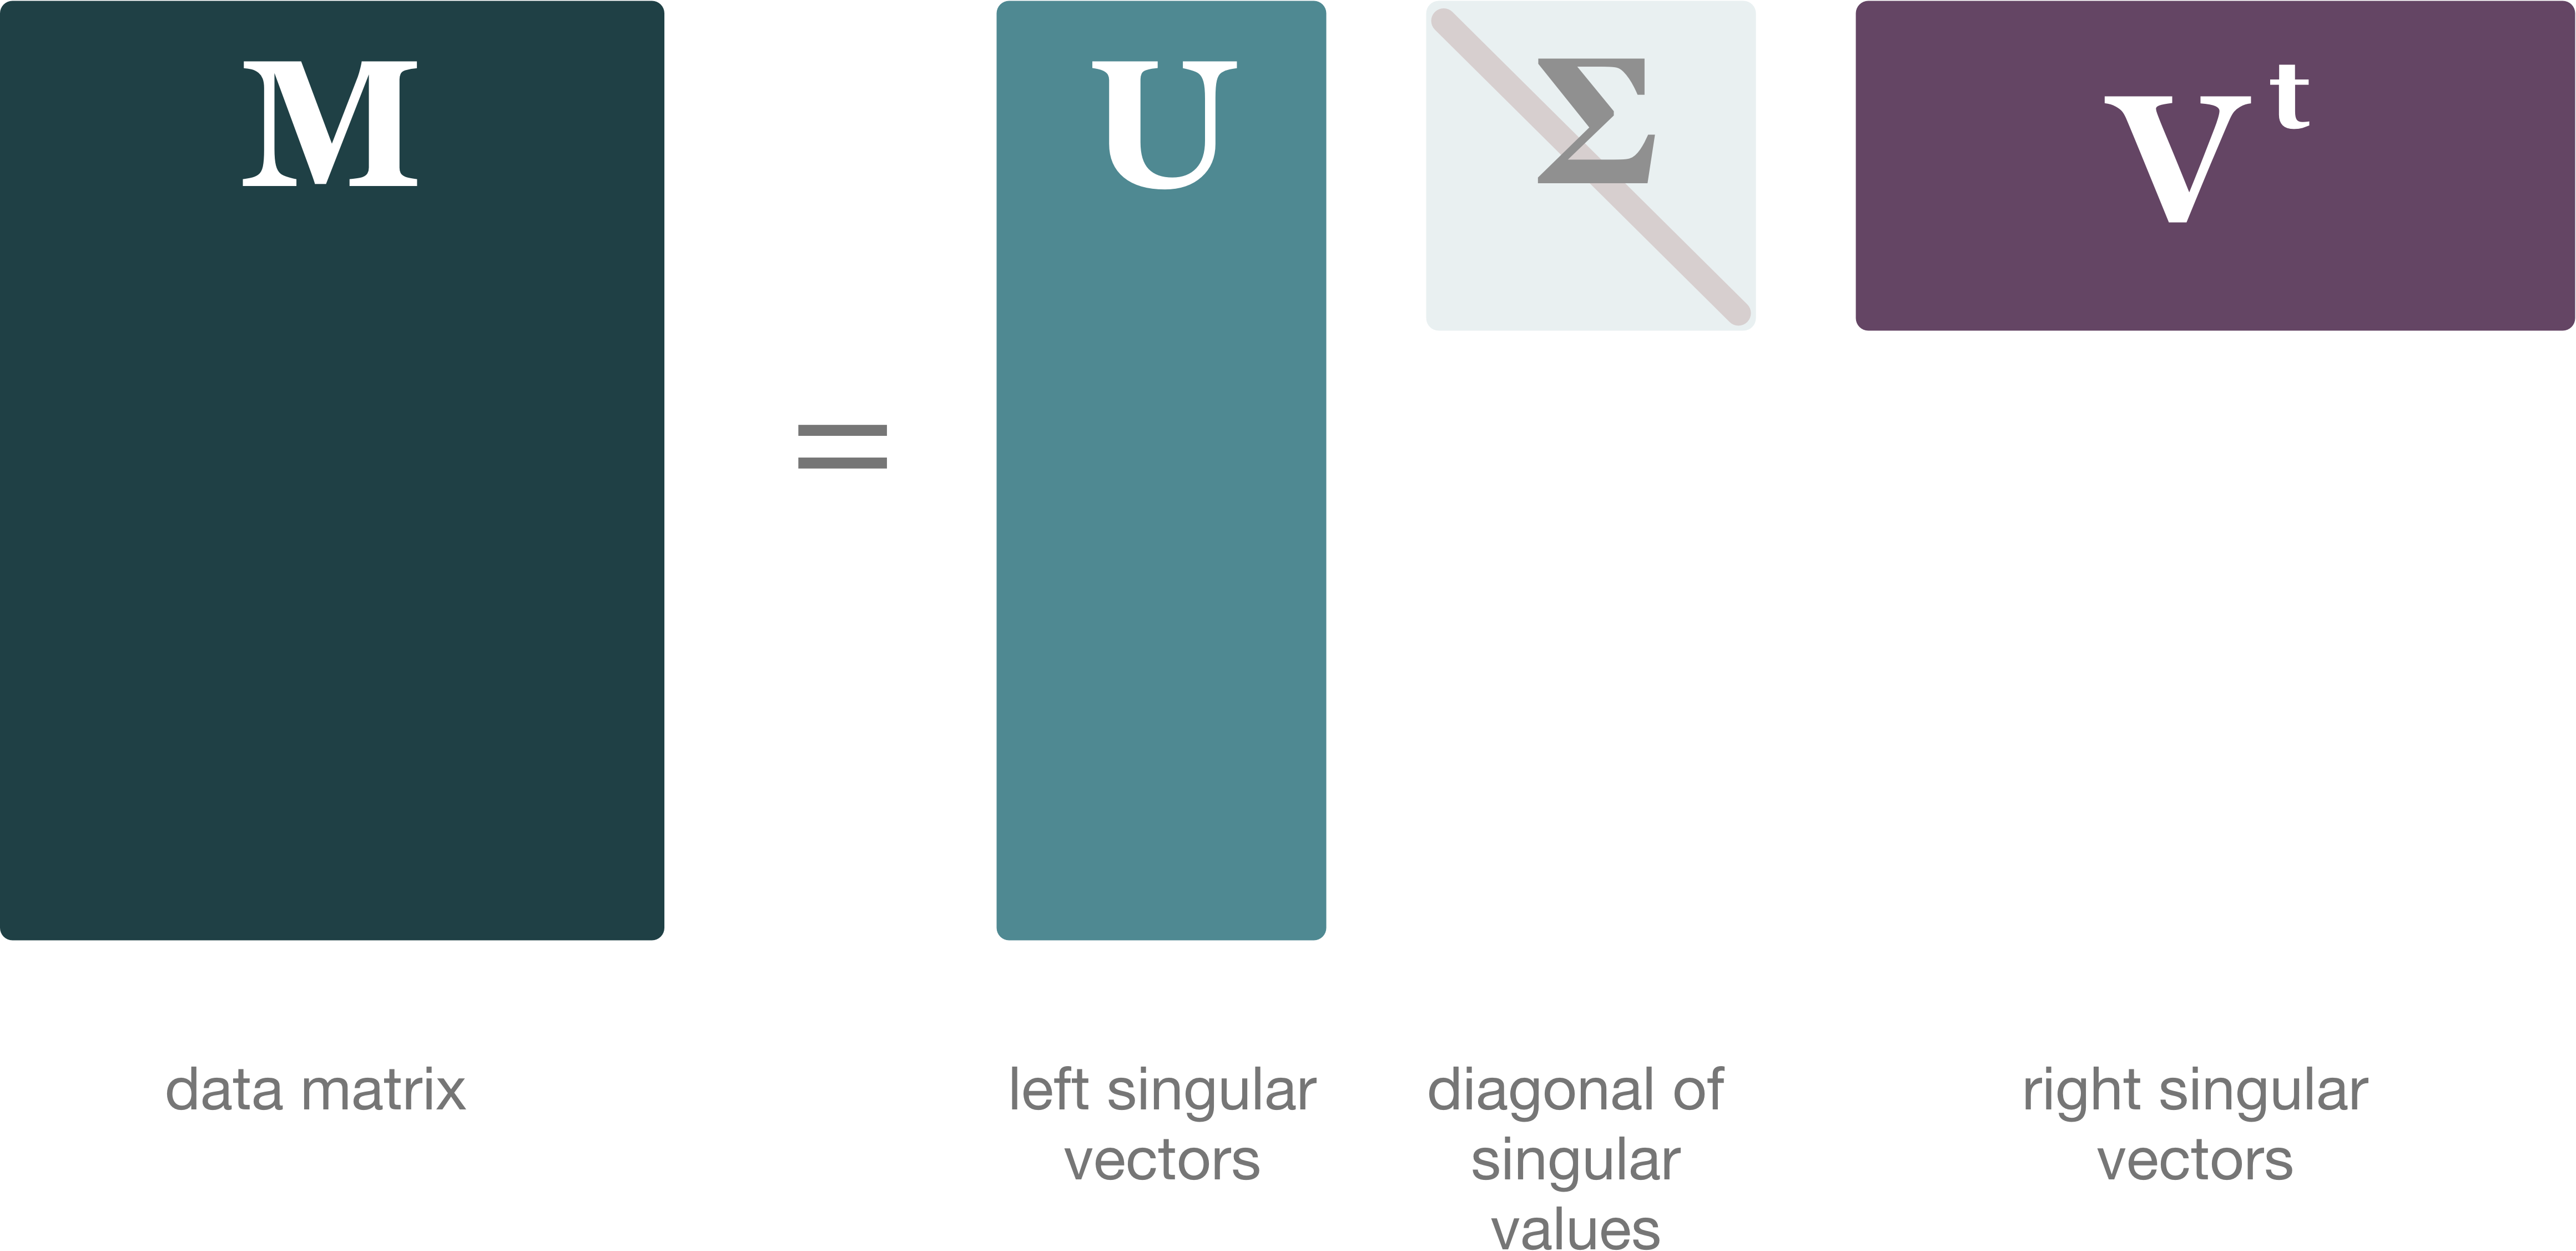

(source for the image: https://dsc-spidal.github.io/harp/docs/harpdaal/svd/)

## Application to Text Representation

This is part of **Latent Semantic Indexing**, which aims at representing documents with regards to semantics (meanings of the documents).

We decompose the Term-Document Matrix Transpose:
* **V** rows, where V is the size of the vocabulary
* **N** columns, where N is the number of document in the corpus
* It is the transpose of the Term-Document Matrix
* Each row represents one term of the vocabulary
* Each column represents one document

We consider the following:
* There are $r$ **topics** in our corpus
* Each topic is made of words
   * Words have weights: some are more representative of the topic than others  
   * We read these weights in the $U$ matrix
* Each document is made of a few topics
   * Topics have weights: some documents talk more about some topics than others
   * We read these weights in the $V$ matrix

# Application

We will use the 20 Newsgroups Dataset.

See [Link](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) or [Link](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)

In [ ]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups(
    subset='all',
    categories=['alt.atheism','talk.religion.misc','comp.graphics','sci.space'],
    remove=('headers', 'footers', 'quotes')
)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(
    stop_words='english',
    min_df=2,
    max_df=0.8,
    max_features=50000,
    token_pattern=r'[a-z]{2,}',
    dtype=np.float64               # needed for SVD
)

In [ ]:
corpus = data.data
term_doc = count.fit_transform(corpus)
vocab = count.get_feature_names()

In [ ]:
print(f'Term-Document Matrix: {term_doc.shape[0]} documents, {term_doc.shape[1]} terms.')

Term-Document Matrix: 3387 documents, 16295 terms.


## Full SVD - The Theory SVD

We try to capture all singular values.

The execution of the next cell will take a few minutes to complete.

In [ ]:
run_full_svd = False   # Switch to True to run the full SVD

In [ ]:
from scipy.sparse.linalg import svds

if run_full_svd:
    x = term_doc.T
    full_u, full_s, full_vt = svds(x, k=min(x.shape)-1)

    print(f'U:  {full_u.shape}')
    print(f'S:  {full_s.shape}')
    print(f'Vt: {full_vt.T.shape}')
    print(f'Rank of matrix: {s.shape[0]}')

When we plot the singular values, most of them have low values, compared to the highest ones.

Note that the values in $\Sigma$ are given in increasing order here.

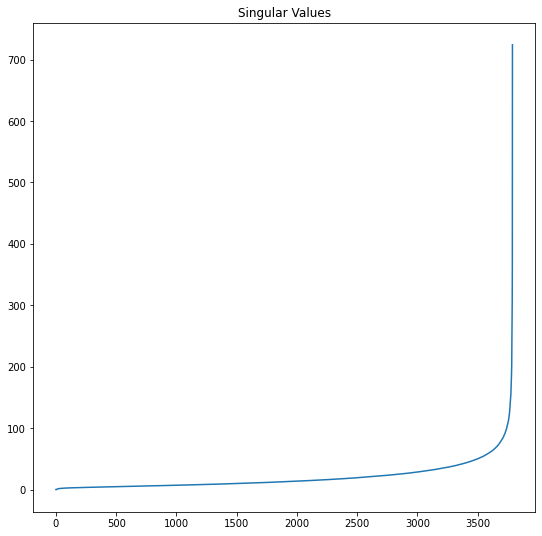

In [ ]:
import matplotlib.pyplot as plt

if run_full_svd:
    plt.figure(figsize=(9, 9))

    _ = plt.plot(range(len(full_s)), full_s)
    _ = plt.title('Singular Values')

## Truncated SVD

At this stage, we see it takes a lot of time to compute ALL the singular values.

We can use Truncated SVD to limit ourselves to K highest singular values.

In this case, we do not obtain $U$, $\Sigma$, $V$ such as $X=U \times \Sigma \times V^T$, rather we obtain $U \times \Sigma \times V^T = \tilde{X} \approx X$.

In this [Link](https://www.overleaf.com/read/rkbqgfsrhbss) is the proof of what approximation of $X$ we are talking about, and what is the link between the $U$ and $V$ from the *Full SVD* and the $U$ and $V$ of the *Truncated SVD*.

We will use plenty of the Truncated SVD in LSI.

In [ ]:
from scipy.sparse.linalg import svds

K = 4
x = term_doc.T
u, s, vt = svds(x, k=K)

In [ ]:
print(f'U: {u.shape}')
print(f'\u03a3: {s.shape}')
print(f'V: {vt.T.shape}')
print(f'Rank of matrix: {s.shape[0]}')

U: (16295, 4)
Σ: (4,)
V: (3387, 4)
Rank of matrix: 4


## Topics

We will now use `sklearn` for Truncated SVD, as the solver is numerically better, and it accepts the term-document matrix as input.

In [ ]:
from sklearn.decomposition import TruncatedSVD

K = 4
svd = TruncatedSVD(n_components=K)
lsa = svd.fit_transform(term_doc)

In [ ]:
for topic in range(K):
    topic_terms = svd.components_[topic, :]
    top_10_indices = topic_terms.argsort()[::-1][:10]
    print(f'Topic {topic:>2}: {"".join([f"{vocab[i]:<15}" for i in top_10_indices])}')

Topic  0: jpeg           image          file           gif            edu            images         format         color          graphics       available      
Topic  1: edu            graphics       pub            data           ftp            mail           ray            send           com            available      
Topic  2: jehovah        elohim         god            lord           jesus          christ         father         mcconkie       said           unto           
Topic  3: space          earth          planet         venus          spacecraft     solar          surface        launch         moon           atmosphere     


As stated below, we have extracted **topics** from the texts themselves.

Each topic is a collection of terms from the vocabulary, each term with a weight that indicates how this term is related to the topic.

Let's explore the topics created by the truncated SVD:
* in $U$, each row stands for a term
* it has $K$ columns, each value is the weight of the term in the topic $K$
* For each topic, we can get the Top 10 words, ie the 10 words with the highest weight in the topic

It is up to the human analyst to evaluate the topics and find a title for each one.

In [ ]:
topic_names = ['Computer_01', 'Computer_02', 'Religion', 'Space']

## Document Representation

The matrix $V$ has N rows:
* Each row for each document
* $K$ columns, each value the weight of a topic in the document
* `lsa` is our *V* matrix

In [ ]:
print(f'LSA matrix: {lsa.shape[0]} documents, {lsa.shape[1]} topics')

LSA matrix: 3387 documents, 4 topics


In [ ]:
import random

from termcolor import colored

doc = random.randint(0, len(corpus))

# Some interesting documents: 241 (negative values), 1254 1660 (well spread over topics)
#doc = 1254

doc_vector = lsa[doc, :]

print(colored('Document at index:', attrs=['bold']), colored(f'{doc}', 'blue', attrs=['bold']))
print(colored('Document Vector:', attrs=['bold']), colored(f'{doc_vector}', 'blue', attrs=['bold']))
print(colored('Document Topics:', attrs=['bold']))

for name, value in zip(topic_names, doc_vector):
    print(' ' * 4 + colored(f'{name:<15}', attrs=['bold']) + ': ' + colored(f'{value:> 4.2f}', 'blue' if value > 0 else 'red'))
print()
print(corpus[doc])

Document at index: 1540
Document Vector: [0.0653272  0.0855462  0.04933061 0.32438576]
Document Topics:
    Computer_01    :  0.07
    Computer_02    :  0.09
    Religion       :  0.05
    Space          :  0.32

Joe,

	your description sounds like one of the  gravity probe  spacecraft
ideas.


## Documents Similarity

Given a query and a list of documents, we can establish the cosine similarity between the query and each document using the SVD.

First we transform the query into a vector, and then we compare it to each document's vector, using the cosine similarity computed on the vectors.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity

lsa_pipeline = Pipeline([('count', count), ('svd', svd)])

query = 'drawing scanner save file'
query_v = lsa_pipeline.transform([query])

print(colored('Query Vector', attrs=['bold']))
for name, value in zip(topic_names, query_v[0]):
    print(' ' * 4 + colored(f'{name:<15}', attrs=['bold']) + ': ' + colored(f'{value:> 4.2f}', 'blue' if value > 0 else 'red'))
print()

sims = cosine_similarity(query_v, lsa)
print(f'Similarity Matrix: {sims.shape[0]} queries, {sims.shape[1]} documents')

Query Vector
    Computer_01    :  0.23
    Computer_02    : -0.08
    Religion       :  0.00
    Space          : -0.04

Similarity Matrix: 1 queries, 3387 documents


**Recall and Precision**

We can see how the top results do not include terms of the query, and yet are relevant to the query.

Compared to BoW, SVD usually benefits to **Recall** (ie, most of the relevant documents will be on top of the ranking), but not to **Precision** (ie, it will also score high some unrelated documents).

The reason why:
* **Recall** improves because it can respond to words that are synonyms and designate the same objects or topics. Documents that would have a low score because they don't use the same words will have higher score as their texts deal with the same topics.
* **Precision** can suffer, because it can misevaluate the topics of a document

In [ ]:
import pandas as pd

from textwrap import fill

sims_df = pd.Series(sims[0, :])
top_10 = sims_df.sort_values(ascending=False)[:10]

for rank, (index, cosine) in enumerate(top_10.iteritems()):
    print(colored(f'#{rank+1:>2}', attrs=['bold']) + colored(f' Score: {cosine:3.2f}', 'blue', attrs=['bold']) +  f' Document at index: {index:>4}' )
    print('*' * 40)
    print(fill(corpus[index], width=80))
    print('*' * 40)
    print()

# 1 Score: 1.00 Document at index:  464
****************************************
 xgif is the grandfather of XV.  --
****************************************

# 2 Score: 1.00 Document at index: 1027
****************************************
what about  qrttoppm < file.dis | ppmtotga > file.tga  ??
****************************************

# 3 Score: 0.99 Document at index: 2962
****************************************
My 24-bit color 600 dpi fladbed scanner can do the job for you. GIF, TIFF, PCX,
BMP. Interested? Please write to me: imagesyz@aol.com
****************************************

# 4 Score: 0.99 Document at index: 3120
****************************************
 I'm not sure if this is free or shareware, but you can try to look to
wsmrsimtel20.army.mil, directory PD1:<MSDOS.DESKPUB>  file OCR104.ZIP . From the
file SIMIBM.LST : OCR104.ZIP    B   93310  910424  Optical character recognition
for scanners.  Hope this helps.
****************************************

# 5 Score: 0.99

# Limitations

## Negative values in vectors

As we saw, some coefficients in document vectors might have negative values (as well, in topics, some words will have a negative weight).

What does it mean?

In the case of document vectors, we know how to interpret a positive value: the document talks about a topic more or less.



---


Example:
```
Document at index: 1540
Document Vector: [0.0653272  0.0855462  0.04933061 0.32438576]
Document Topics:
    Computer_01    :  0.07
    Computer_02    :  0.09
    Religion       :  0.05
    Space          :  0.32
```

It talks very little about religion or computers, but a lot about space.


---


With negative values:
```
Document at index: 241
Document Vector: [ 0.09363319 -0.00596175  0.12408198  0.05959491]
Document Topics:
    Computer_01    :  0.09
    Computer_02    : -0.01
    Religion       :  0.12
    Space          :  0.06
```
* Negative values indicate that the document talks a little about the opposite of computer?
* What would be the opposite of computer?
   * Anything else than computers?
   * Humans?
   * Sentient beings?
   * (...)
* In terms of semantic, there is no description for the opposite of a topic


## Non-normed vector

The weights do not sum up to 1, and since there are negative values, it is also difficult to evaluate the importance of a topic with regards to the other topics.

Searching for the documents with the highest content with regards to one topic is then difficult: `0.5` in one case is not the same importance as `0.5` in another case.

For example, with the two documents above:
* Document 1540: `0.07` in `computer_01`, in a vector where the sum of components is `0.53`
* Document 241: `0.09` in `computer_01`, in a vector there the sum of components is `0.26`
* How do we compare these values to evaluate if the topic `computer_01` is more represented in one document or the other?
